In [194]:
!pip install nfl_data_py
!python3 -m pip install pystan
!pip3 install nest_asyncio


In [235]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stan
import nest_asyncio
import seaborn as sns

from google.colab import drive


In [3]:
drive.mount('drive')

Mounted at drive


In [110]:
data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'fantasy_points_ppr', 'week', 'season', 'recent_team', 'opponent_team'])
data.columns = ['player', 'position', 'ppr', 'week', 'season', 'team', 'opponent_team']
data = data[(data['week'] <= 18)]
data.head()

Downcasting floats.


,player,position,ppr,week,season,team,opponent_team
0,Tom Brady,QB,27.160000,1,2021,TB,DAL
1,Tom Brady,QB,29.639999,2,2021,TB,ATL
2,Tom Brady,QB,28.680000,3,2021,TB,LA
3,Tom Brady,QB,11.060000,4,2021,TB,NE
4,Tom Brady,QB,37.740002,5,2021,TB,MIA


In [59]:
player_seasons = data.groupby(['player', 'season', 'position', 'team'])['ppr'].sum().reset_index()
player_seasons

,player,season,position,team,ppr
0,A.J. Brown,2021,WR,TEN,180.899994
1,A.J. Brown,2022,WR,PHI,299.600006
2,A.J. Brown,2023,WR,PHI,289.600006
3,A.J. Dillon,2021,RB,GB,185.599991
4,A.J. Dillon,2022,RB,GB,167.600006
...,...,...,...,...,...
1915,Zay Jones,2021,WR,LV,105.900002
1916,Zay Jones,2022,WR,JAX,198.100006
1917,Zay Jones,2023,WR,JAX,78.099998
1918,Zonovan Knight,2022,RB,NYJ,59.000000


In [60]:
# helper function to get 2nd highest value in each group
def get_second_largest(group):
    return group.nlargest(2, 'ppr').iloc[1]

Get individual dataframes for each position

In [83]:
qb = data[(data['position'] == 'QB')].sort_values(by = ['team', 'season', 'week'])
rb = data[(data['position'] == 'RB')].sort_values(by = ['team', 'season', 'week'])
wr = data[(data['position'] == 'WR')].sort_values(by = ['team', 'season', 'week'])
te = data[(data['position'] == 'TE')].sort_values(by = ['team', 'season', 'week'])

Get season-level dataframes of the best/2nd best player at a position on each team

In [89]:
qbs = player_seasons[(player_seasons)['position'] == 'QB'].sort_values(by = ['team', 'season'])
idx = qbs.groupby(['team', 'season'])['ppr'].idxmax()
qbs = qbs.loc[idx]

rb1s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
idx = rb1s.groupby(['team', 'season'])['ppr'].idxmax()
rb1s = rb1s.loc[idx]

rb2s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
rb2s = rb2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

wr1s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
idx = wr1s.groupby(['team', 'season'])['ppr'].idxmax()
wr1s = wr1s.loc[idx]

wr2s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
wr2s = wr2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

tes = player_seasons[(player_seasons)['position'] == 'TE'].sort_values(by = ['team', 'season'])
idx = tes.groupby(['team', 'season'])['ppr'].idxmax()
tes = tes.loc[idx]

Get week-level dataframes for each position

In [91]:
qb = pd.merge(qb, qbs, on = ['player', 'team', 'season'], how = 'inner')
rb1 = pd.merge(rb, rb1s, on = ['player', 'team', 'season'], how = 'inner')
rb2 = pd.merge(rb, rb2s, on = ['player', 'team', 'season'], how = 'inner')
wr1 = pd.merge(wr, wr1s, on = ['player', 'team', 'season'], how = 'inner')
wr2 = pd.merge(wr, wr2s, on = ['player', 'team', 'season'], how = 'inner')
te = pd.merge(te, tes, on = ['player', 'team', 'season'], how = 'inner')

Get matchup dataframe

In [151]:
matchups = data[['season', 'week', 'team', 'opponent_team']].drop_duplicates().sort_values(['team', 'season', 'week'])

In [112]:
position_df_data = {
    'season' : [],
    'week' : [],
    'team' : [],
    'opponent_team' : [],
    'qb' : [],
    'rb1' : [],
    'rb2' : [],
    'wr1' : [],
    'wr2' : [],
    'te' : [],
    'opp_qb' : [],
    'opp_rb1' : [],
    'opp_rb2' : [],
    'opp_wr1' : [],
    'opp_wr2' : [],
    'opp_te' : []
}

position_df = pd.DataFrame(position_df_data)

In [117]:
teams = matchups['team'].unique()

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV',
       'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF',
       'TB', 'TEN', 'WAS'], dtype=object)

In [168]:
for season in range(2021,2024):
  for team in range(32):
    for week in range(18):

      # get team points for each position-week
      qb_row = qb[(qb['season'] == season) & (qb['team'] == teams[team]) & (qb['week'] == week+1)]
      rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == teams[team]) & (rb1['week'] == week+1)]
      rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == teams[team]) & (rb2['week'] == week+1)]
      wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == teams[team]) & (wr1['week'] == week+1)]
      wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == teams[team]) & (wr2['week'] == week+1)]
      te_row = te[(te['season'] == season) & (te['team'] == teams[team]) & (te['week'] == week+1)]

      qb_ppr = 0 if (qb_row.empty) else qb_row.iloc[0, 2]
      rb1_ppr = 0 if (rb1_row.empty) else rb1_row.iloc[0, 2]
      rb2_ppr = 0 if (rb2_row.empty) else rb2_row.iloc[0, 2]
      wr1_ppr = 0 if (wr1_row.empty) else wr1_row.iloc[0, 2]
      wr2_ppr = 0 if (wr2_row.empty) else wr2_row.iloc[0, 2]
      te_ppr = 0 if (te_row.empty) else te_row.iloc[0, 2]

      # get opposing team points
      opponent = matchups[(matchups['season'] == season) & (matchups['week'] == week+1) & (matchups['team'] == teams[team])]
      if (opponent.empty):
          opponent = ''
          curr_team = ''
          opp_qb_ppr = 0
          opp_rb1_ppr = 0
          opp_rb2_ppr = 0
          opp_wr1_ppr = 0
          opp_wr2_ppr = 0
          opp_te_ppr = 0
      else:
        opponent = opponent.iloc[0, 3]
        curr_team = teams[team]

        opp_qb_row = qb[(qb['season'] == season) & (qb['team'] == opponent) & (qb['week'] == week+1)]
        opp_rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == opponent) & (rb1['week'] == week+1)]
        opp_rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == opponent) & (rb2['week'] == week+1)]
        opp_wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == opponent) & (wr1['week'] == week+1)]
        opp_wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == opponent) & (wr2['week'] == week+1)]
        opp_te_row = te[(te['season'] == season) & (te['team'] == opponent) & (te['week'] == week+1)]

        opp_qb_ppr = 0 if (opp_qb_row.empty) else opp_qb_row.iloc[0, 2]
        opp_rb1_ppr = 0 if (opp_rb1_row.empty) else opp_rb1_row.iloc[0, 2]
        opp_rb2_ppr = 0 if (opp_rb2_row.empty) else opp_rb2_row.iloc[0, 2]
        opp_wr1_ppr = 0 if (opp_wr1_row.empty) else opp_wr1_row.iloc[0, 2]
        opp_wr2_ppr = 0 if (opp_wr2_row.empty) else opp_wr2_row.iloc[0, 2]
        opp_te_ppr = 0 if (opp_te_row.empty) else opp_te_row.iloc[0, 2]

      new_row = {
          'season' : season,
          'week' : week+1,
          'team' : curr_team,
          'opponent_team' : opponent,
          'qb' : qb_ppr,
          'rb1' : rb1_ppr,
          'rb2' : rb2_ppr,
          'wr1' : wr1_ppr,
          'wr2' : wr2_ppr,
          'te' : te_ppr,
          'opp_qb' : opp_qb_ppr,
          'opp_rb1' : opp_rb1_ppr,
          'opp_rb2' : opp_rb2_ppr,
          'opp_wr1' : opp_wr1_ppr,
          'opp_wr2' : opp_wr2_ppr,
          'opp_te' : opp_te_ppr
      }
      position_df.loc[len(position_df)] = new_row

In [196]:
nest_asyncio.apply()

position_df = position_df.drop_duplicates()
position_df = position_df[(position_df['team'] != '')]

stan_input = position_df[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te']].to_numpy()

In [190]:
mean = stan_input['te'].mean()
sd = stan_input['te'].std()
print(mean)
print(sd)

7.681349703413577
7.037273088973911


Stan model

In [199]:
stan_input.shape

(1630, 12)

In [206]:
merged_data = {
    'N': stan_input.shape[0],
    'K': stan_input.shape[1],
    'y': stan_input
}

Stan code (this took like 5x less time on R lmao)

In [207]:
stan_code = """
  // Stan model to estimate correlations between QB, RB, WR1, WR2, and TE fantasy points
  data {
    int<lower=1> N;          // Number of observations (e.g., games or players)
    int<lower=1> K;          // Number of variables (e.g., QB, RB, WR1, WR2, TE)
    matrix[N, K] y;
  }

  parameters {
    vector[K] mu;            // Means of fantasy points for QB, RB, WR1, WR2, and TE
    vector<lower=0>[K] sigma; // Standard deviations for QB, RB, WR1, WR2, and TE
    corr_matrix[K] Rho;      // Correlation matrix for the variables
  }

  transformed parameters {
    cov_matrix[K] Sigma;     // Covariance matrix

    // Construct the covariance matrix from standard deviations and correlations
    Sigma = quad_form_diag(Rho, sigma);
  }

  model {
    // Priors for means
    mu[1] ~ normal(12.6, 5);   // Prior for QB mean fantasy points
    mu[2] ~ normal(12, 5);   // Prior for RB1 mean fantasy points
    mu[3] ~ normal(5.5, 5);   // Prior for RB2 mean fantasy points
    mu[4] ~ normal(13.6, 5);   // Prior for WR1 mean fantasy points
    mu[5] ~ normal(8.2, 5);   // Prior for WR2 mean fantasy points (similar to WR1)
    mu[6] ~ normal(7.5, 5);    // Prior for TE mean fantasy points

    // Priors for opponent means
    mu[7] ~ normal(12.6, 5);   // Prior for QB mean fantasy points
    mu[8] ~ normal(12, 5);   // Prior for RB1 mean fantasy points
    mu[9] ~ normal(5.5, 5);   // Prior for RB2 mean fantasy points
    mu[10] ~ normal(13.6, 5);   // Prior for WR1 mean fantasy points
    mu[11] ~ normal(8.2, 5);   // Prior for WR2 mean fantasy points (similar to WR1)
    mu[12] ~ normal(7.5, 5);    // Prior for TE mean fantasy points

    // Priors for standard deviations
    sigma[1] ~ normal(9.6, 10);   // Prior for QB sigma
    sigma[2] ~ normal(8.9, 10);   // Prior for RB1 sigma
    sigma[3] ~ normal(6.1, 10);   // Prior for RB2 sigma
    sigma[4] ~ normal(9.7, 10);   // Prior for WR1 sigma
    sigma[5] ~ normal(7.6, 10);   // Prior for WR2 sigma
    sigma[6] ~ normal(6.8, 10);   // Prior for TE sigma

    // Priors for opponent standard deviations
    sigma[7] ~ normal(9.6, 10);   // Prior for QB sigma
    sigma[8] ~ normal(8.9, 10);   // Prior for RB1 sigma
    sigma[9] ~ normal(6.1, 10);   // Prior for RB2 sigma
    sigma[10] ~ normal(9.7, 10);   // Prior for WR1 sigma
    sigma[11] ~ normal(7.6, 10);   // Prior for WR2 sigma
    sigma[12] ~ normal(6.8, 10);   // Prior for TE sigma

    // Priors for correlations
    Rho ~ lkj_corr(2);       // LKJ prior for correlation matrix
    //print(Rho);

    // Likelihood: Multivariate normal distribution for observed data
    for (i in 1:N) {
      y[i] ~ multi_normal(mu, Sigma);
    }
  }

  generated quantities {
    corr_matrix[K] corr;     // Generated correlation matrix for output
    corr = Rho;              // Assign the correlation matrix for output
  }
"""

model = stan.build(stan_code, data = merged_data)
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_jqob6px_/model_ef7kdwml.stan', line 56, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Warning in '/tmp/httpstan_jqob6px_/model_ef7kdwml.stan', line 35, column 20: Argument
    13.6 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_jqob6px_/model_ef7kdwml.stan', line 33, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_jqob6px_/model_ef7kdwml.stan', line 32, column 19: Argument
    12.6 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual s

In [250]:
fit_df = fit.to_frame()
fit_vars = fit_df.describe()

corr_mean = np.zeros(shape = (12, 12))
corr_sd = np.zeros(shape = (12, 12))

for i in range(12):
  for j in range(12):
    corr_mean[i,j] = fit_vars.iloc[1, 31 + i*12 + j]
    corr_sd[i,j] = fit_vars.iloc[2, 31 + i*12 + j]

In [234]:
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80
print(corr_mean)
print("\n\n")
print(corr_sd)

[[ 1.          0.10166905  0.05099566  0.33867888  0.28058169  0.22538679  0.15987166  0.03746949  0.0163313   0.04565065  0.11474954  0.05633993]
 [ 0.10166905  1.         -0.16959468  0.00394753  0.01089737  0.00205181  0.03682941 -0.03411772 -0.03897039 -0.01506945  0.02958264  0.03142452]
 [ 0.05099566 -0.16959468  1.         -0.00522917 -0.01037995 -0.0265933   0.01703025 -0.03896896 -0.01046028 -0.01088108 -0.00522007 -0.0089347 ]
 [ 0.33867888  0.00394753 -0.00522917  1.          0.03929023  0.01465594  0.04712953 -0.01592335 -0.01002469  0.04902521  0.00749956  0.06833259]
 [ 0.28058169  0.01089737 -0.01037995  0.03929023  1.         -0.03361979  0.11570485  0.02943497 -0.00483251  0.00676461  0.11623703  0.05995647]
 [ 0.22538679  0.00205181 -0.0265933   0.01465594 -0.03361979  1.          0.05792813  0.03080026 -0.00806204  0.06744944  0.06060124 -0.01369142]
 [ 0.15987166  0.03682941  0.01703025  0.04712953  0.11570485  0.05792813  1.          0.10144525  0.05205242  0.33984

array([[33.56000137,  5.30000019, 14.60000038, ..., 14.89999962,  2.        ,  4.9000001 ],
       [33.09999847,  2.5999999 , 12.5       , ..., 18.5       , 15.89999962,  3.5       ],
       [18.54000092, 18.29999924, 14.5       , ..., 12.19999981,  8.80000019,  0.        ],
       ...,
       [-1.75999999,  0.        , 10.19999981, ..., 15.80000019,  2.70000005,  7.5999999 ],
       [ 6.65999985, 11.60000038,  5.5999999 , ..., 24.39999962, 18.20000076,  5.9000001 ],
       [ 7.42000008, 10.5       ,  6.5999999 , ..., 35.5       , 16.20000076, 12.89999962]])

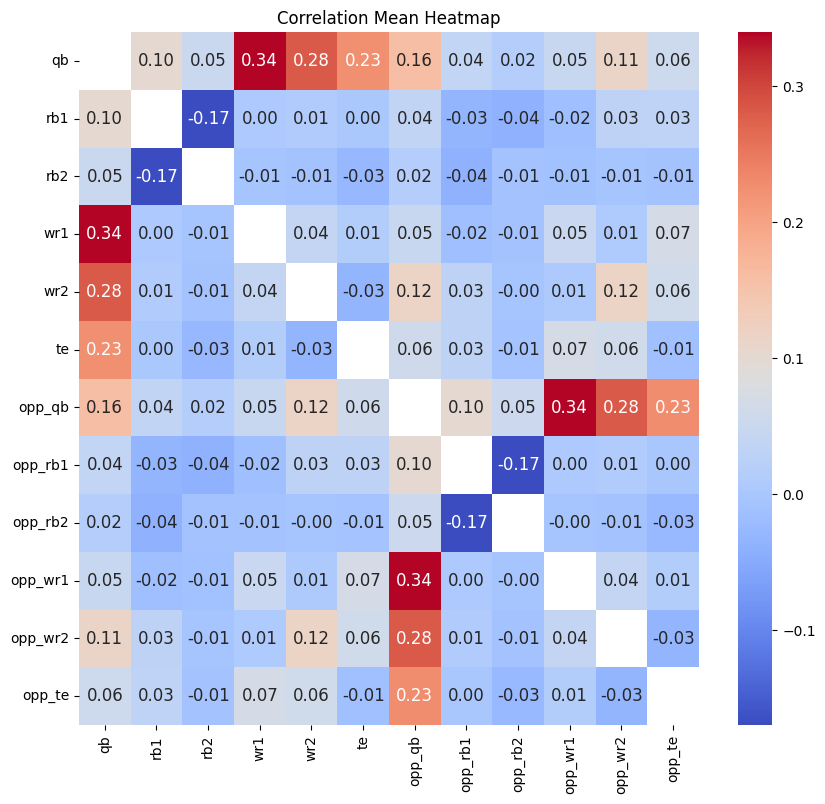

In [253]:
plt.figure(figsize = (10, 9))

mask = np.eye(corr_mean.shape[0], dtype=bool)

row_names = ['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te']
col_names = row_names

sns.heatmap(corr_mean, annot = True, cmap = 'coolwarm', fmt='.2f', annot_kws={'size': 12}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation Mean Heatmap")
plt.show()

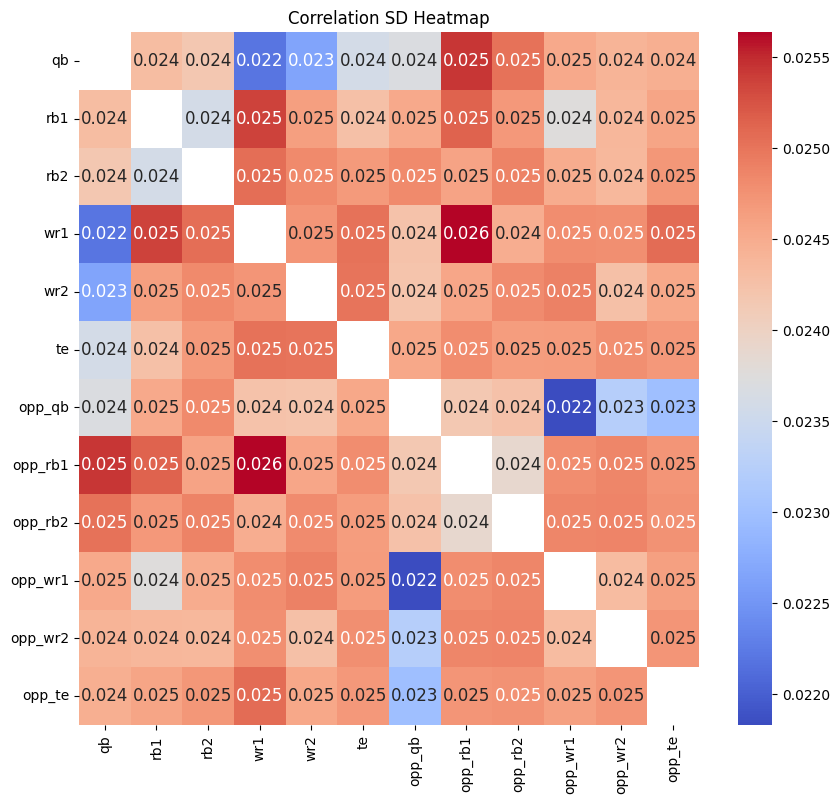

In [256]:
plt.figure(figsize = (10, 9))

mask = np.eye(corr_sd.shape[0], dtype=bool)

row_names = ['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te']
col_names = row_names

sns.heatmap(corr_sd, annot = True, cmap = 'coolwarm', fmt='.3f', annot_kws={'size': 12}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation SD Heatmap")
plt.show()

In [ ]:
data.to_csv('data.csv')
!cp data.csv "drive/My Drive/"